# Price Prediction with NLP

The main challenge is to extract features that can be useful to predict the price of each haus.

One can think in various ways to do that:

1. Targeting information that we want to know and that it was not included in the structured data ( like if it has gute Verbindungen or gut Blik) and apply methods of Text Mining like NER, NEN or similar. The advantages of this methods are that we have full control over the features that we are getting and can understand the features. The drawbacks though, are that it is necessary to label the data, and, althoug we could use active learning to use as less data as possible, we would still need labelled data.

2. Having the price as a target, and training a model combining the features at the input of the model, or in the last layers after a transformer model has extrated features from the text. The clear advantage here, is that we can do this task automatically, without labelled data, cause we already have the price. The drawbacks though, are two: First, the text changes quite a lot from example to example, so, models will have hard times trying to identify features that properly predict the price. The second drawback is that we only can evaluate how good the features are by looking at the improvement of CV results (There are methods for model explanability in NLP but they recognize the words or group of words that are more important for the prediction).

In this notebook I perform an adaptation of the Bert transformer model for regression (it is only avaliable for classification in huggingface). I incorpore fully conected layers to give a the end a regression prediction and I optimize the mse. What I wanted to test here is, if it was even possible that the model learn this kind of data.

As future research, I propose to incorporate the features created by the model (taking the last layer of the model for each prediction) to the other model. Another option is to give the structured features at the exit of the transformer model, and optimize the features with the extracted features from the text in an End2End fashion. My fear here is that, the neural network might give too much attention to the structured features, so regularization techniques might be used to avoid this behaviour, and extract features from the text that are independent to the structured ones.

In [1]:
!pip install transformers
!pip install torch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import BertPreTrainedModel, BertModel
from transformers import AutoConfig, AutoTokenizer

from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [3]:
import pandas as pd
df = pd.read_parquet('data/data_train.parquet.gzip')
df = df[:10000]
df['id'] = df.index
df.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,geo_krs_baseRent_size,geo_plz_baseRent_size,streetPlain_baseRent_size,garden_baseRent_size,heatingType_baseRent_size,telekomTvOffer_baseRent_size,condition_baseRent_size,interiorQual_baseRent_size,typeOfFlat_baseRent_size,id
237905,Nordrhein_Westfalen,94.0,central_heating,ONE_YEAR_FREE,NaN,0,0,6,2.74,40.0,...,2327,158,12.0,42098,102952.0,181826.0,NaN,NaN,25127.0,237905
143718,Hamburg,630.0,central_heating,ONE_YEAR_FREE,NaN,0,0,6,4.48,40.0,...,2993,42,NaN,172469,102952.0,181826.0,NaN,NaN,104805.0,143718
53329,Schleswig_Holstein,150.0,gas_heating,None,NaN,0,1,2,2.98,NaN,...,711,61,NaN,172469,15908.0,NaN,53184.0,NaN,25127.0,53329
198945,Nordrhein_Westfalen,100.0,self_contained_central_heating,None,NaN,0,0,7,3.61,NaN,...,1516,237,8.0,172469,15301.0,NaN,20978.0,65361.0,25127.0,198945
193723,Brandenburg,93.0,central_heating,ONE_YEAR_FREE,NaN,0,1,6,3.90,40.0,...,408,146,16.0,42098,102952.0,181826.0,20978.0,65361.0,25127.0,193723


Represent the distribution of targets again

<AxesSubplot:>

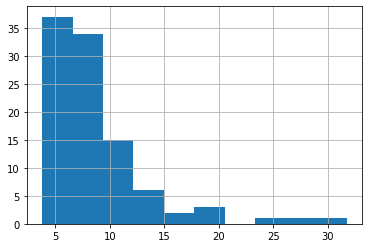

In [4]:
df['description_all'] = df['description'].astype(str) + df['facilities'].astype(str)
# Target 1: baseRentSquareMeter // Target 2: price_costs_square_meter
df['target'] = df['baseRentSquareMeter']
df['excerpt'] = df['description_all']
df=df[['id', 'excerpt', 'target']]
df = df.dropna()
len(df)
df.target.hist()

### Clean data with Regex

In [5]:
from bert_utils import clean_text

df['cleaned_description'] = df.excerpt.apply(clean_text)

In [6]:
df = df.reset_index(drop=True)
df.cleaned_description[3]
len(df.cleaned_description[3])
description = df.cleaned_description
df

,id,excerpt,target,cleaned_description
0,237905,NoneKabelanschluss; Gartennutzung; Isolierverg...,6.600040,nonekabelanschluss; gartennutzung; isolierverg...
1,143718,Die Wohnung ist mit einer Küche mit hellen Ein...,11.888112,die wohnung ist mit einer küche mit hellen ein...
2,53329,Die Wohnung befindet sich im Erdgeschoss eines...,9.036145,die wohnung befindet sich im erdgeschoss eines...
3,198945,Die komplett sanierte 2 Zi. Wohnung liegt im E...,7.857143,die komplett sanierte 2 zi. wohnung liegt im e...
4,193723,Frisch renovierte 1-Zimmer-Wohnung am Tschirch...,8.010753,frisch renovierte 1-zimmer-wohnung am tschirch...
...,...,...,...,...
95,142035,Es ist ein traumhaft schöner Speicher mit alte...,7.087379,es ist ein traumhaft schöner speicher mit alte...
96,102929,Penthouse Wohnung über den Dächern von Mainz\n...,9.278351,penthouse wohnung über den dächern von mainz\n...
97,190098,Wie bieten Ihnen hier eine hübsche 1-Raumwohnu...,9.918526,wie bieten ihnen hier eine hübsche 1-raumwohnu...
98,158990,+++++++\rDieses Objekt kann nur möbliert angem...,19.149533,+++++++\rdieses objekt kann nur möbliert angem...


### Bert maximal input sequence is 512. We need to filder the long descriptions. With shorter input sequence we improve the training.

In [7]:
import numpy as np
def filter_long_descriptions( df, max_len):
    indices = []
    for i in range(len(df)):
        if len(description[i]) <= max_len-2:
            indices.append(i)
    return indices


short_descriptions = filter_long_descriptions(df.cleaned_description.tolist(), 400)
df1 = df.loc[short_descriptions]

In [8]:
df = df1.reset_index(drop=True)
df = df.drop(['excerpt'], axis=1)
df['excerpt'] = df['cleaned_description']
df = df.drop(['cleaned_description'], axis=1)
dftrain = df
df.excerpt[7]

'extras:\n- treppenhausreinigung\n- hausmeisterservice\n- winterdienst\n- gegensprechanlage\n\nallgemein:\n- waschtrockner\n- vorderhaus\n\nräume:\n- verputzte wände\n- parkettboden\n\nküche:\n- geschirrspüler\n- elektroherd, cerankochfeld\n- kühl-/gefrierkombination\n\nbadezimmer:\n- dusche\n\n'

## Let's visualize the word count for all examples

In [9]:
word_count = dftrain['excerpt'].apply(lambda x: len(x.split()))

/home/user/anaconda3/envs/docker_guillermo/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


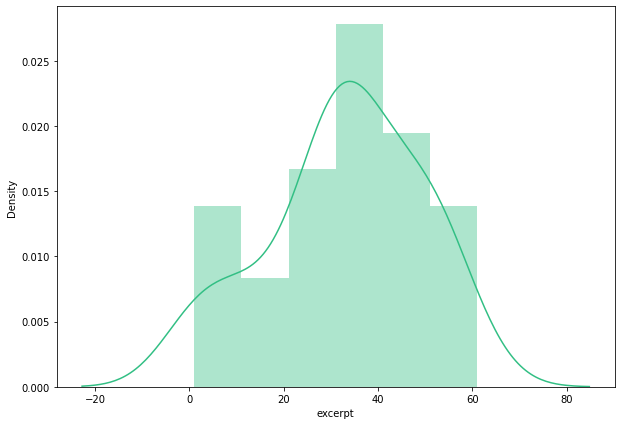

In [10]:
fig = plt.figure(figsize=[10,7])
sns.distplot(word_count, color=sns.xkcd_rgb['greenish teal'])
plt.show()

# Divide in Train and Validation

In [11]:
from sklearn.model_selection import train_test_split
test_size = 0.2
seed = 42
dftrain, dftest = train_test_split(dftrain, test_size=test_size, 
                             random_state=seed)

dftrain = dftrain.reset_index(drop=True)
dftest = dftest.reset_index(drop=True)

In [12]:
train_data, validation = train_test_split(dftrain, test_size=0.25, random_state=21)
train_data = train_data.reset_index(drop=True)
validation = validation.reset_index(drop=True)
train_data.head()

,id,target,excerpt
0,53329,9.036145,die wohnung befindet sich im erdgeschoss eines...
1,81002,14.554795,extras:\n- treppenhausreinigung\n- hausmeister...
2,218585,5.000000,es handelt sich um ein schönes apartment in ei...
3,198121,17.956204,das angebotene mietobjekt befindet sich in ein...
4,163698,11.428571,das objekt verfügt über drei hübsche zimmer. b...


In [13]:
wc_test = dftest['excerpt'].apply(lambda x: len(x.split()))

In [14]:
wc_test

0    55
1    47
2    49
3    15
4     1
5    41
6    53
7    31
Name: excerpt, dtype: int64

In [15]:
word_count.max()

61

## Config

In [16]:
import os 
MODEL_OUT_DIR = 'bert_regressor'
## Model Configurations
MAX_LEN_TRAIN = 205
MAX_LEN_VALID = 205
MAX_LEN_TEST = 205
BATCH_SIZE = 64
LR = 1e-3
NUM_EPOCHS = 10
NUM_THREADS = 1  ## Number of threads for collecting dataset
MODEL_NAME = "dbmdz/bert-base-german-cased"
# MODEL_NAME = 'bert-base-uncased'

if not os.path.isdir(MODEL_OUT_DIR):
    os.makedirs(MODEL_OUT_DIR)

## Scripts

### Data Loader

In [17]:
class Excerpt_Dataset(Dataset):

    def __init__(self, data, maxlen, tokenizer): 
        #Store the contents of the file in a pandas dataframe
        self.df = data.reset_index()
        #Initialize the tokenizer for the desired transformer model
        self.tokenizer = tokenizer
        #Maximum length of the tokens list to keep all the sequences of fixed size
        self.maxlen = maxlen

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):    
        #Select the sentence and label at the specified index in the data frame
        excerpt = self.df.loc[index, 'excerpt']
        try:
            target = self.df.loc[index, 'target']
        except:
            target = 0.0
        identifier = self.df.loc[index, 'id']
        #Preprocess the text to be suitable for the transformer
        tokens = self.tokenizer.tokenize(excerpt) 
        tokens = ['[CLS]'] + tokens + ['[SEP]'] 
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] 
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] 
        #Obtain the indices of the tokens in the BERT Vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens) 
        input_ids = torch.tensor(input_ids) 
        #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attention_mask = (input_ids != 0).long()
        
        target = torch.tensor(target, dtype=torch.float32)
        
        return input_ids, attention_mask, target

### Bert Regressor

In [18]:
class BertRegresser(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        #The output layer that takes the [CLS] representation and gives an output
        self.cls_layer1 = nn.Linear(config.hidden_size,128)
        self.relu1 = nn.ReLU()
        self.ff1 = nn.Linear(128,128)
        self.tanh1 = nn.Tanh()
        self.ff2 = nn.Linear(128,1)

    def forward(self, input_ids, attention_mask):
        #Feed the input to Bert model to obtain contextualized representations
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #Obtain the representations of [CLS] heads
        logits = outputs.last_hidden_state[:,0,:]
        output = self.cls_layer1(logits)
        output = self.relu1(output)
        output = self.ff1(output)
        output = self.tanh1(output)
        output = self.ff2(output)
        return output

## Train function

In [19]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    best_acc = 0
    for epoch in trange(epochs, desc="Epoch"):
        model.train()
        train_loss = 0
        for i, (input_ids, attention_mask, target) in enumerate(iterable=train_loader):
            optimizer.zero_grad()  
            
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
            
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            
            loss = criterion(output, target.type_as(output))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        print(f"Training loss is {train_loss/len(train_loader)}")
        val_loss = evaluate(model=model, criterion=criterion, dataloader=val_loader, device=device)
        print("Epoch {} complete! Validation Loss : {}".format(epoch, val_loss))

## Evaluation function

In [20]:
def evaluate(model, criterion, dataloader, device):
    model.eval()
    mean_acc, mean_loss, count = 0, 0, 0

    with torch.no_grad():
        for input_ids, attention_mask, target in (dataloader):
            
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
            output = model(input_ids, attention_mask)
            
            mean_loss += criterion(output, target.type_as(output)).item()
#             mean_err += get_rmse(output, target)
            count += 1
            
    return mean_loss/count

In [21]:
def get_rmse(output, target):
    err = torch.sqrt(metrics.mean_squared_error(target, output))
    return err

## Predict function

In [22]:
def predict(model, dataloader, device):
    predicted_label = []
    actual_label = []
    with torch.no_grad():
        for input_ids, attention_mask, target in (dataloader):
            
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
            output = model(input_ids, attention_mask)
                        
            predicted_label += output
            actual_label += target
            
    return predicted_label

## Config

In [23]:

import torch
from transformers import BertModel, BertTokenizerFast

## Configuration loaded from AutoConfig 
config = AutoConfig.from_pretrained(MODEL_NAME)
## Tokenizer loaded from AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# Creating the model from the desired transformer model
model = BertRegresser.from_pretrained(MODEL_NAME, config=config)
## GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## Putting model to device
model = model.to(device)
## Takes as the input the logits of the positive class and computes the binary cross-entropy 
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()
## Optimizer
optimizer = optim.Adam(params=model.parameters(), lr=LR)

Some weights of the model checkpoint at dbmdz/bert-base-german-cased were not used when initializing BertRegresser: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertRegresser from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertRegresser from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertRegresser were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['ff2.weight', 'cls_layer1.bias', 'ff1.bias', 'ff2.bias'

## Prep data

In [24]:
dftest.head()

,id,target,excerpt
0,142544,5.095238,das objekt ist ein hochwertig saniertes und de...
1,228946,5.601956,diese sanierte wohnung mit loggia liegt in grü...
2,221806,7.065217,bei dem objekt handelt es sich um eine helle ...
3,128932,5.494505,- gepflegte anlage\n- zweigeschossige bauweise...
4,251769,5.010195,nonenone


In [25]:
## Training Dataset
train_set = Excerpt_Dataset(data=train_data, maxlen=MAX_LEN_TRAIN, tokenizer=tokenizer)
valid_set = Excerpt_Dataset(data=validation, maxlen=MAX_LEN_VALID, tokenizer=tokenizer)
test_set = Excerpt_Dataset(data=dftest, maxlen=MAX_LEN_TEST, tokenizer=tokenizer)


## Data Loaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)

# print(len(train_loader))

## Train

In [26]:
train(model=model, 
      criterion=criterion,
      optimizer=optimizer, 
      train_loader=train_loader,
      val_loader=valid_loader,
      epochs = 10,
     device = device)

Epoch:   0%|                                             | 0/10 [00:00<?, ?it/s]/home/user/anaconda3/envs/docker_guillermo/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch:   0%|                                             | 0/10 [00:08<?, ?it/s]


KeyboardInterrupt: 

## Prediction

In [ ]:
output = predict(model, test_loader, device)

In [ ]:
output[0].shape

In [ ]:
output[0]

In [ ]:
out2 = []

In [ ]:
for out in output:
    out2.append(out.cpu().detach().numpy())

In [ ]:
out = np.array(out2).reshape(len(out2))

In [ ]:
submission = pd.DataFrame({'id': dftest['id'], 'target':out})

In [ ]:
submission.to_csv('predictions_only_text_100000.csv', index=False)